# Figures for the Methodology

This notebook makes the schematic figures for the Methodology section.

## Provenance information

Load libraries and print the version information.

In [1]:
%matplotlib inline
from __future__  import division
from tempfile import NamedTemporaryFile
from StringIO import StringIO
import numpy as np
from IPython.display import Image
from matplotlib.font_manager import FontProperties
from fatiando.mesher import Tesseroid
from fatiando.constants import MEAN_EARTH_RADIUS
from fatiando.vis import myv, mpl
import fatiando

We'll make the graphics using the plotting functions in [Fatiando a Terra](http://www.fatiando.org). The engine for the 3D plots is [Mayavi](http://code.enthought.com/projects/mayavi/).

In [2]:
print('Fatiando a Terra version: {}'.format(fatiando.__version__))

Fatiando a Terra version: 0.3


In [3]:
!tessgz --version

1.2.0

We'll set the general style of matplotlib here so that we don't have to tweak this for every plot.

In [4]:
mpl.rc('font', size=8, family='Arial')

## Effect of distance and number of GLQ nodes on the computed effects

The code below computes the $g_{zz}$ effect of a tesseroid on a regular grid with varying height and number of GLQ nodes.

First, we set the dimensions of the tesseroid and write that to a temporary file.

In [5]:
tess_area = (-52, -45, -23, -16)

In [6]:
modelfile = NamedTemporaryFile(delete=False)
modelfile.write('{} {} {} {} 0 -20000 2670'.format(*tess_area))
modelfile.close()
print(modelfile.name)

/tmp/tmpqg3Xtf


Next, we assemble a pipeline on a string that will use `tessgrd` to create a regular grid and pipe that to `tessgxy` to calculate the effect.

In [7]:
area = (-70, -30, -35, 0)
shape = (100, 100)
pipeline = ' | '.join(
    ['tessgrd -r{area[0]}/{area[1]}/{area[2]}/{area[3]} -b{shape[0]}/{shape[1]} -z{height}',
     'tessgxy {model} -a -o{order:d}/{order:d}/{order:d}'])

Now we can insert the computation parameters on the string and execute it in the shell using IPython's `!` syntax.
Then, we capture the stdout in `data` and load the data in numpy arrays using `loadtxt` and some `StringIO` magic.

In [8]:
cmd = pipeline.format(area=area, shape=shape, height=400e03, order=2, model=modelfile.name)
data = !$cmd
high = np.loadtxt(StringIO('\n'.join(data)), unpack=True)

In [9]:
cmd = pipeline.format(area=area, shape=shape, height=150e03, order=2, model=modelfile.name)
data = !$cmd
low = np.loadtxt(StringIO('\n'.join(data)), unpack=True)

In [10]:
high_order = 30
cmd = pipeline.format(area=area, shape=shape, height=150e03, order=high_order, 
                      model=modelfile.name)
data = !$cmd
low_highorder = np.loadtxt(StringIO('\n'.join(data)), unpack=True)

Now all that's left is to make the figure and save it as EPS.

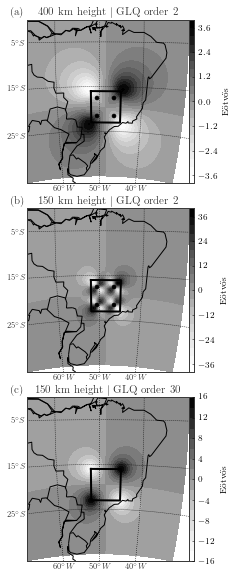

In [11]:
grids = [high, low, low_highorder]
orders = [2, 2, high_order]

fig, subplots = mpl.subplots(3, 1, squeeze=True, figsize=(3.33, 8), dpi=600)
bm = mpl.basemap(area, projection='poly')

w, e, s, n = tess_area
# To plot the outline of the tesseroid
tx, ty = bm([w, e, e, w, w], [n, n, s, s, n])
# Scale and make a list of the 2x2 GLQ nodes
nodes = np.array([-0.577350269, 0.577350269])
nodes_lon = 0.5*(e - w)*nodes + 0.5*(e + w)
nodes_lat = 0.5*(n - s)*nodes + 0.5*(n + s)
nodex, nodey = bm(*np.meshgrid(nodes_lon, nodes_lat))

index = ['(a)', '(b)', '(c)']
for i, order, grid, ax in zip(index, orders, grids, subplots):
    mpl.sca(ax)
    mpl.text(-0.1, 1.03, i, fontsize=11, transform=ax.transAxes)
    lon, lat, h, g = grid
    ax.set_title('{:.0f} km height $|$ GLQ order {}'.format(h[0]/1000, order),
                 fontsize=11)
    vmax = np.abs(g).max()
    vmin = -vmax
    mpl.contourf(lon, lat, g, shape, 20, vmin=vmin, vmax=vmax, basemap=bm, 
                 cmap=mpl.cm.Greys)
    mpl.colorbar(orientation='vertical', pad=0., aspect=30).set_label(r'E\"otv\"os')
    bm.plot(tx, ty, '-k', linewidth=2)
    if i in ['(a)', '(b)']:
        bm.plot(nodex, nodey, 'ok', markersize=4)
    bm.drawparallels([-25, -15, -5], labels=[1, 0, 0, 0], linewidth=0.5)
    bm.drawmeridians([-60, -50, -40], labels=[0, 0, 0, 1], linewidth=0.5)
    mpl.draw_countries(bm, style='-')
    mpl.draw_coastlines(bm)
mpl.tight_layout(h_pad=1.5)

In [12]:
fig.savefig('../figs/vary-height-and-order.eps')

Clean-up the temp file with the model.

In [13]:
!rm -f $modelfile.name

## Recursive discretization

This function takes a computation point, a tesseroid, and a distance/size ratio and recursively breaks the tesseroid into smaller ones until `distance > size*ratio` for every smaller tesseroid. This is what happens in the tesseroid computations automatically.

In [5]:
def discretize(tesseroid, point, ratio):
    d2r = np.pi/180
    lon, lat, h = point
    lon *= d2r
    lat *= d2r
    sinlat = np.sin(lat)
    coslat = np.cos(lat)
    r = h + MEAN_EARTH_RADIUS
    result = []
    stack = [tesseroid]
    while stack:
        tess = stack.pop()
        # compute the distance to the center of the tesseroid
        rt = 0.5*(tess.top + tess.bottom) + MEAN_EARTH_RADIUS
        latt = d2r*0.5*(tess.s + tess.n)
        lont = d2r*0.5*(tess.w + tess.e)
        cospsi = sinlat*np.sin(latt) + coslat*np.cos(latt)*np.cos(lon - lont)
        distance = np.sqrt(r**2 + rt**2 - 2*r*rt*cospsi)
        # compute the sizes of the tesseroid
        r2 = tess.top + MEAN_EARTH_RADIUS
        dlon = (r2*np.arccos(np.sin(latt)**2 
                + (np.cos(latt)**2)*np.cos(d2r*(tess.e - tess.w))))
        dlat = (r2*np.arccos(np.sin(d2r*tess.n)*np.sin(d2r*tess.s)
                + np.cos(d2r*tess.n)*np.cos(d2r*tess.s)))
        dr = tess.top - tess.bottom
        nlon, nlat, nr = 1, 1, 1
        if distance/dlon < ratio:
            nlon = 2
        if distance/dlat < ratio:
            nlat = 2
        if distance/dr < ratio:
            nr = 2
        if nlon == 1 and nlat == 1 and nr == 1:
            result.append(tess)
        else:
            stack.extend(tess.split(nlon, nlat, nr))
    return result

I'll make the figures with the tesseroid and computation point defined below.

In [6]:
tesseroid = Tesseroid(-55, -25, -80, -70, 500e3, 0)
point = [-40, -70, 800e3]

This function sets the camera position for the 3D plot. This way, all plots will be from the same angle.

In [7]:
def setview(scene):
    scene.scene.camera.position = [
        13245978.057767538, -30621946.584093191, -7206532.4158068281]
    scene.scene.camera.focal_point = [
        -23549.659742131294, 2441999.8237691643, -6224267.6728611523]
    scene.scene.camera.view_angle = 2.0615843020800004
    scene.scene.camera.view_up = [
        -0.0023574328511045649, 0.028749561740884784, -0.99958386602128579]
    scene.scene.camera.clipping_range = [
        16338386.090352792, 55257696.473242983]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()

Plot the original tesseroid.

In [13]:
scene = myv.figure(zdown=False, size=(1200, 900))
myv.earth(opacity=1, color=(0.7, 0.7, 0.7))
myv.continents(linewidth=2)
# Split the tesseroid so that it doesn't look so square in the plot
myv.tesseroids(tesseroid.split(35, 35, 20), edges=False, color=(0.4, 0.4, 0.4))
myv.points([point], size=30000, spherical=True)
myv.meridians(range(0, 360, 30))
myv.parallels(range(-90, 0, 15))
setview(scene)
myv.savefig('../figs/tesseroid-split-whole.png')
myv.mlab.close()

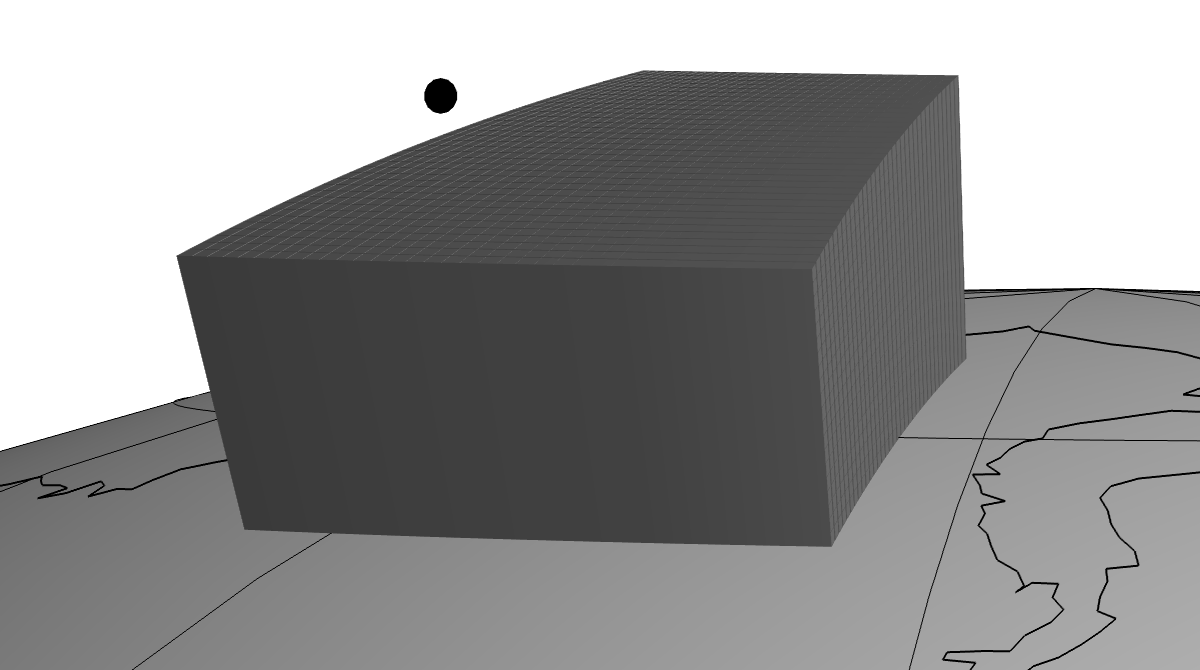

In [14]:
Image(filename='../figs/tesseroid-split-whole.png', width=800)

Now make plots of the discretization for various distance/size ratios.

In [9]:
for split in [1, 2, 6]:
    scene = myv.figure(zdown=False, size=(1200, 900))
    myv.earth(opacity=1, color=(0.7, 0.7, 0.7))
    myv.continents(linewidth=2)
    model = discretize(tesseroid, point, split)
    print "Number of tesseroids:", len(model)
    myv.tesseroids(model, edges=False, color=(0.4, 0.4, 0.4))
    myv.tesseroids(model, style='wireframe', linewidth=5, color=(0.9, 0.9, 0.9))
    myv.points([point], size=30000, spherical=True)
    myv.meridians(range(0, 360, 30))
    myv.parallels(range(-90, 0, 15))
    setview(scene)
    myv.savefig('../figs/tesseroid-split-ratio%g.png' % (split))
    myv.mlab.close()

Number of tesseroids: 4
Number of tesseroids: 38
Number of tesseroids: 936


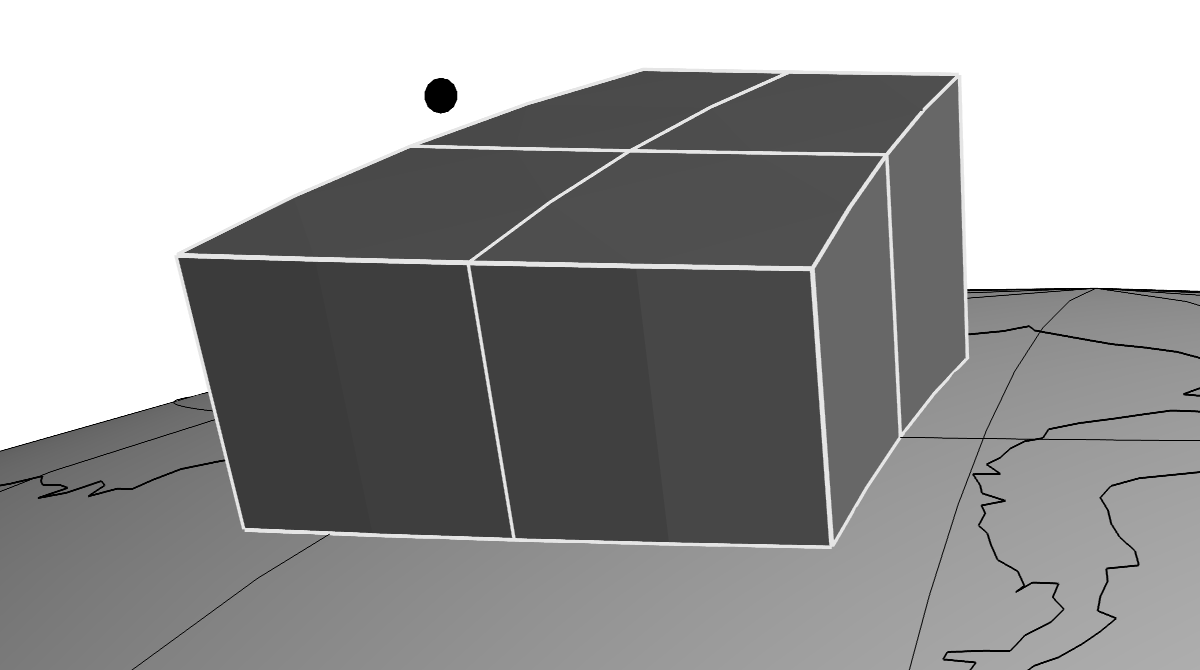

In [10]:
Image(filename='../figs/tesseroid-split-ratio1.png', width=800)

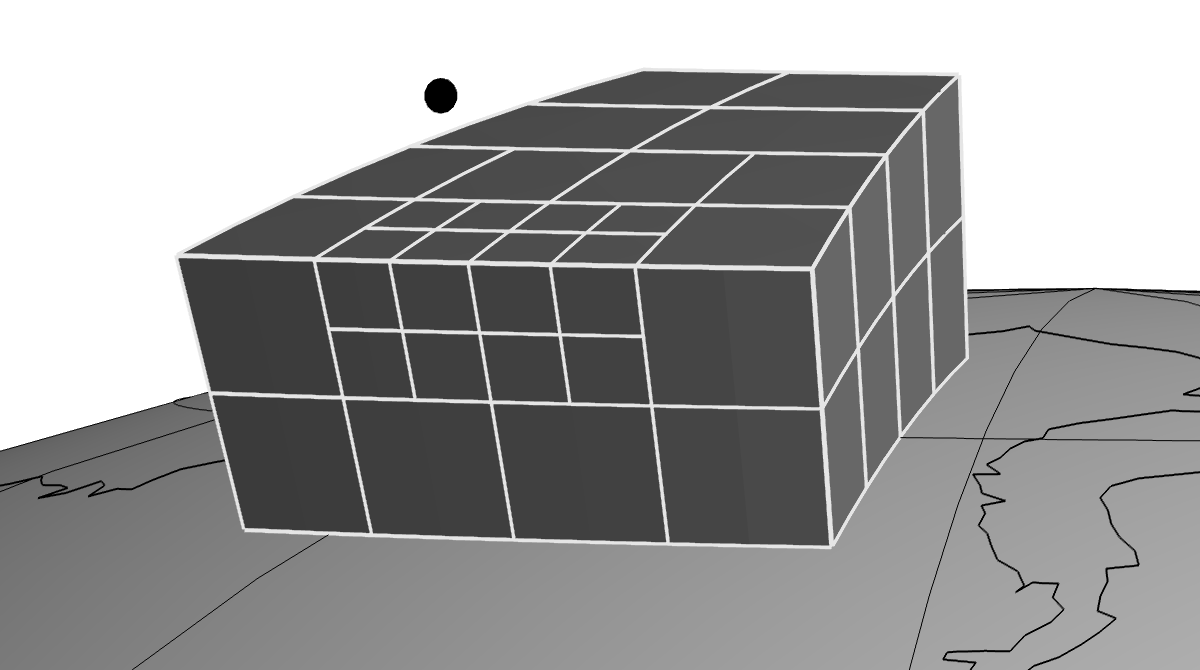

In [11]:
Image(filename='../figs/tesseroid-split-ratio2.png', width=800)

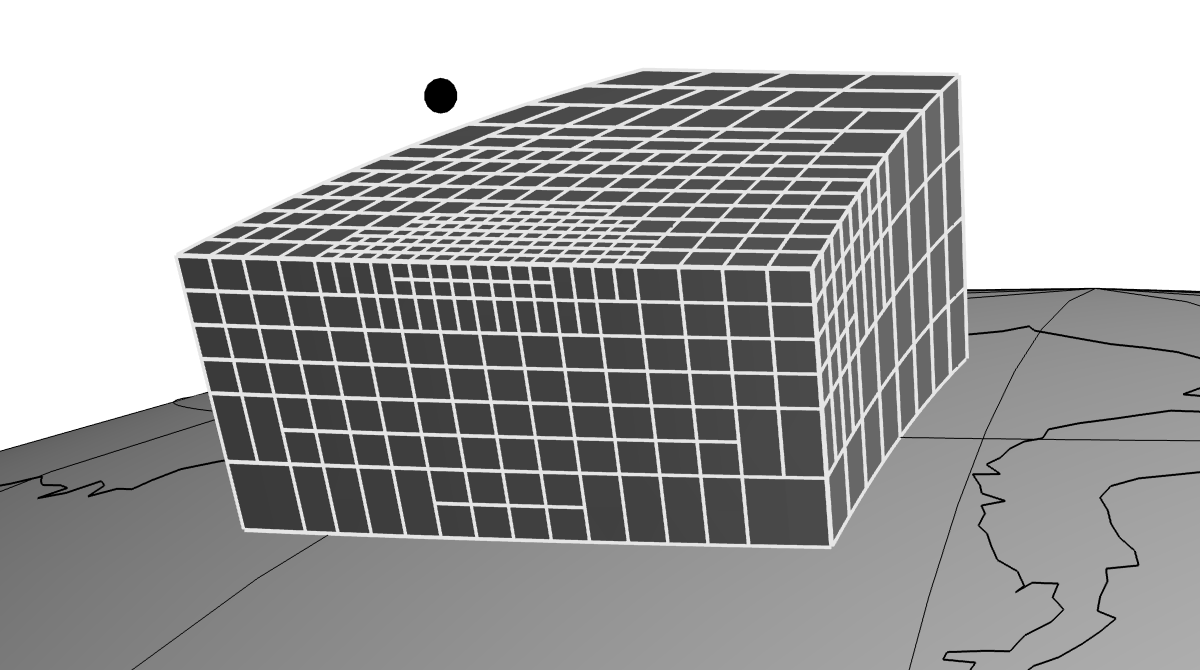

In [12]:
Image(filename='../figs/tesseroid-split-ratio6.png', width=800)